In [1]:
using StanSample, Distributions, Dates
using DataFrames, CSV

In [2]:
ENV["JULIA_CMDSTAN_HOME"] = expanduser("~/cmdstan");

In [3]:
include("../src/rt-from-frequency-dynamics.jl")
using .rt_from_frequency_dynamics

In [4]:
cases_df = DataFrame(CSV.File("../data/location-case-counts.tsv"))
seq_df = DataFrame(CSV.File("../data/location-variant-sequence-counts.tsv"))

,date,location,variant,sequences
,Date,String,String,Int64
1,2021-01-02,Alabama,other,3
2,2021-01-03,Alabama,other,3
3,2021-01-04,Alabama,other,12
4,2021-01-05,Alabama,other,72
5,2021-01-06,Alabama,other,36
6,2021-01-07,Alabama,other,1
7,2021-01-08,Alabama,other,1
8,2021-01-09,Alabama,other,7
9,2021-01-10,Alabama,other,3


In [5]:
# 1. Make dataframe
loc = "Alabama"
LD = LineageData(filter(row -> row.location == loc, seq_df), filter(row -> row.location == loc, cases_df))
LD.sequence_counts

273×8 Matrix{Int64}:
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0  12
 0  0  0   0  0  0  0  72
 0  0  0   0  0  0  0  36
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   7
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0  17
 0  0  0   0  0  0  0   3
 0  0  0   0  0  0  0   1
 0  0  0   0  0  0  0   2
 ⋮               ⋮     
 0  0  0  37  0  0  0   0
 0  0  0  57  0  0  0   1
 0  0  0  51  0  0  0   1
 0  0  0  56  0  0  0   0
 0  0  0  43  0  0  0   0
 0  0  0  30  0  0  0   0
 0  0  0  29  0  0  0   0
 0  0  0  36  0  0  0   0
 0  0  0  33  0  0  0   0
 0  0  0  28  0  0  0   0
 0  0  0  22  0  0  0   0
 0  0  0  13  0  0  0   0

In [9]:
# 2. Get lifetimes
g, onset = get_standard_delays()

# 3. Create the model for Rt
n_days = length(unique(LD.dates))
rt_model = SplineTrend(20, n_days, 4)
priors = [["LAS"]]
seed_L = 7
forecast_L = 0

# 4. Choose lineage model type
LM =  FixedLineageModel(g, onset, rt_model, priors, seed_L, forecast_L)

FixedLineageModel{Float64}([0.0013570708164475438, 0.030252383582115523, 0.1248726218372186, 0.21989262129982626, 0.23434297788835956, 0.1800507935166118, 0.11003557415528875, 0.05680884455133395, 0.025772058657759778, 0.010556189208093536, 0.003980424684790984, 0.0014017344178233193, 0.0004660914523152426], [3.8872052302944836e-7, 0.0013781561063394194, 0.055284375808597706, 0.3417218112141225, 0.780268761669684, 1.0, 0.9014831923033185, 0.6502995817497046, 0.4056024823983106, 0.22963239715075728, 0.12180655617080503, 0.06183884788596803, 0.030491658924558254, 0.014754237581045646, 0.00705796544686744, 0.0033558114933791216, 0.0015921209508521382], SplineTrend(20, [1.0, 15.31578947368421, 29.63157894736842, 43.94736842105263, 58.26315789473684, 72.57894736842105, 86.89473684210526, 101.21052631578947, 115.52631578947368, 129.84210526315786, 144.1578947368421, 158.47368421052633, 172.78947368421052, 187.10526315789474, 201.42105263157893, 215.73684210526318, 230.05263157894737, 244.368

In [13]:
model_dir = "../data/sims/tests"
MS = make_stan(LM, LD, "test-states", "$model_dir/test_fixed")


/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan updated.


Main.rt_from_frequency_dynamics.ModelStan(SampleModel("test-states", "\nfunctions {\n  \n  int get_L_nonzero(int[] Z, int L){\n    int L_nonzero = 0;\n    for (i in 1:L){\n      if(Z[i] > 0){ \n        L_nonzero += 1;\n      }\n    }\n    return L_nonzero;\n  }\n\n  int[] get_nonzero_idx(int[] Z, int L_nonzero, int L){\n    int cur_idx = 1;\n    int non_zero_idx[L_nonzero];\n\n    for (i in 1:L){\n      if(Z[i] > 0){\n        non_zero_idx[cur_idx] = i;\n        cur_idx += 1;\n      }\n    }\n    return non_zero_idx;\n  }\n\n  /* real convolve_with_lifetime(vector X, vector Y_rev, int t, int l){ */\n  /*   int lx = max(1, t-l); */\n  /*   int hx = min(l, t-1); */\n  /*   return dot_product(X[lx:(t-1)], tail(Y_rev, hx)); */  \n  /* } */\n\n  matrix get_weekend_mat(int L){\n        matrix[L, 7] wk_mat = rep_matrix(0, L, 7);\n        for (i in 1:L){\n           wk_mat[i, (i % 7)+1] = 1;\n        }\n        return(wk_mat);\n    }\n  \n  vector get_infections(vector R, real I0, vector g_rev,

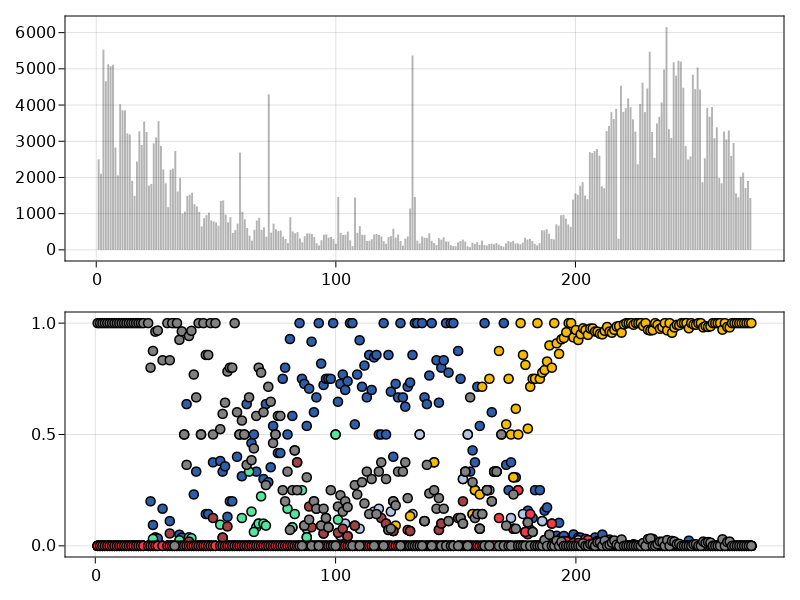

In [17]:
using CairoMakie
fig = Figure()
ax = fig[2,1] = Axis(fig)
plot_observed_frequencies!(ax, MS)
ax2 = fig[1,1] = Axis(fig)
plot_cases!(ax2, MS)
fig

In [18]:
run!(MS, num_warmup = 1000, num_samples=1000, num_chains=4, get_samples=true)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is nan, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is nan, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained var

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained var

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is nan, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is nan, but must be positive finite! (in '/Users/marlinfiggins/Documents/rt-from-frequency-dynamics/data/sims/tests/test_fixed/test-states.stan', line 229, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained var

19021-element Vector{String}:
 "b.1"
 "b.2"
 "b.3"
 "b.4"
 "b.5"
 "b.6"
 "b.7"
 "b.8"
 "b.9"
 "b.10"
 "b.11"
 "b.12"
 "b.13"
 ⋮
 "obs_freqs.262.8"
 "obs_freqs.263.8"
 "obs_freqs.264.8"
 "obs_freqs.265.8"
 "obs_freqs.266.8"
 "obs_freqs.267.8"
 "obs_freqs.268.8"
 "obs_freqs.269.8"
 "obs_freqs.270.8"
 "obs_freqs.271.8"
 "obs_freqs.272.8"
 "obs_freqs.273.8"

In [58]:
colors = lineage_colors = ["#2e5eaa", "#5adbff", "#f03a47", "#56e39f","#b4c5e4",  "#f5bb00", "#9e4244", "#808080"] 

8-element Vector{String}:
 "#2e5eaa"
 "#5adbff"
 "#f03a47"
 "#56e39f"
 "#b4c5e4"
 "#f5bb00"
 "#9e4244"
 "#808080"

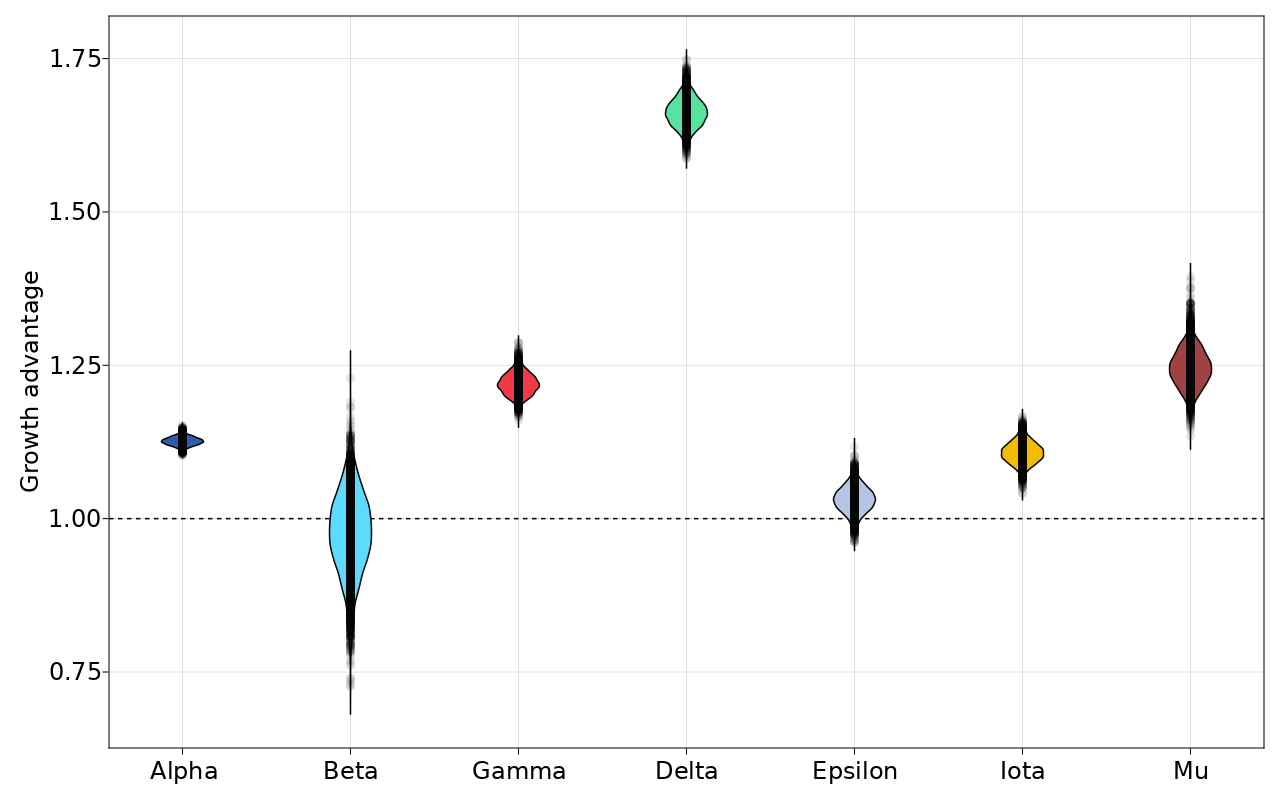

In [59]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Growth advantage")
plot_growth_advantage!(ax, MS)
ax.xtickformat = xs -> LD.seq_names[convert.(Int, xs)]
fig

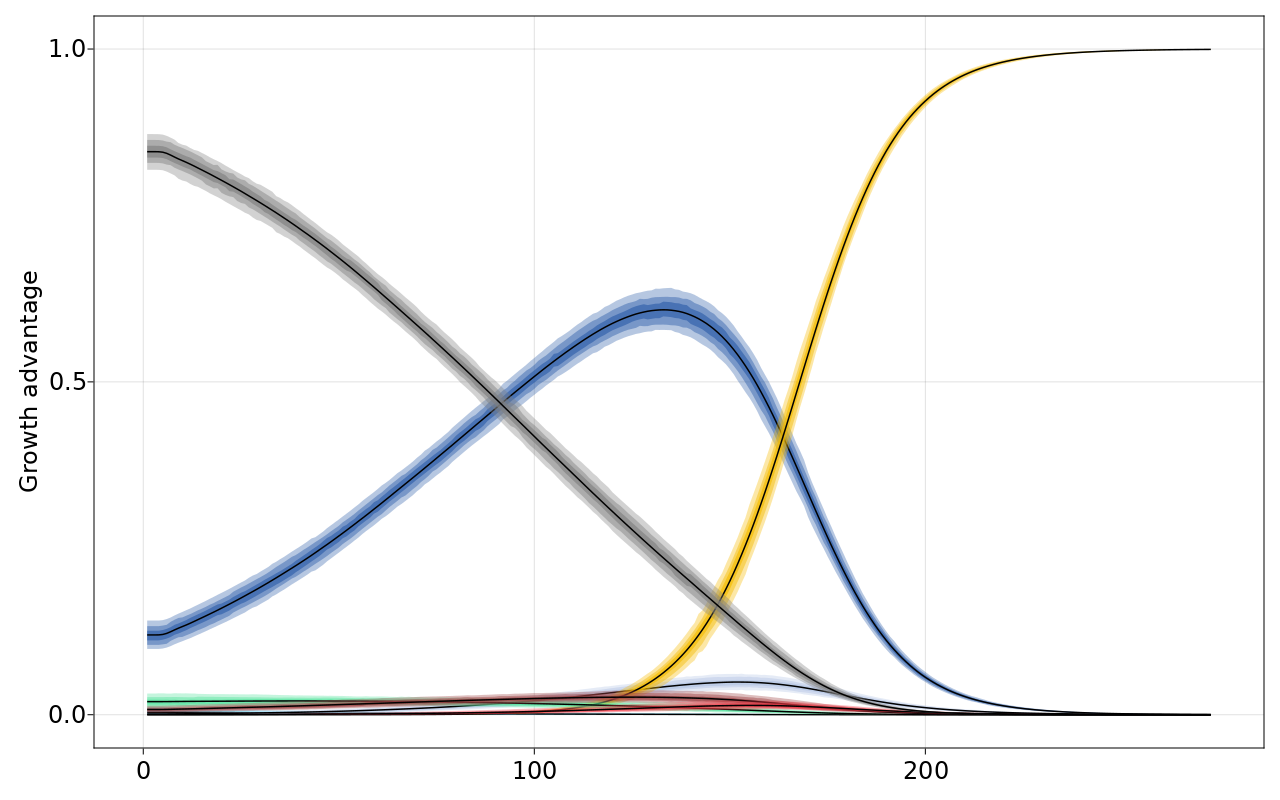

In [42]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Growth advantage")
plot_lineage_frequency!(ax, MS)
fig

In [48]:
function figure_2(MS, LD, colors; figsize=(1800, 1800), fontsize=32, font="Helvetica")
    dates_num, seed_L, forecast_L, N_lineage = unpack_data(MS)
    dates = LD.dates 
    
    seq_labels = LD.seq_names
    #lineage_map = get_sequence_map(seq_labels)
    #WHO_seq_names = [lineage_to_WHO[lineage] for lineage in seq_labels]
    
    cases = MS.data["cases"]
    counts =  MS.data["num_sequenced"]
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = figsize, fontsize = fontsize, font = font)
    
    
    # Posterior smooth prevalence 
    g_smooth = fig[1:4,1] = GridLayout()
    ax_smooth = Axis(g_smooth[1,1], ylabel = "Posterior Smoothed Cases")
    plot_cases!(ax_smooth, MS)
    plot_smoothed_EC!(ax_smooth, MS)
    add_monthly_dates!(ax_smooth, dates)
    hidexdecorations!(ax_smooth, grid = false)

    # Frequency plot 
    g_freq = fig[5:8, 1] = GridLayout()
    ax_freq = Axis(g_freq[1,1],ylabel = "Posterior Lineage Frequency")
    plot_observed_frequencies!(ax_freq, MS; colors = colors)
    plot_lineage_frequency!(ax_freq, MS; colors = colors)
    add_monthly_dates!(ax_freq, dates)
    
    linkxaxes!(ax_smooth, ax_freq)
    
    # Posterior lineage cases
    g_smooth_lin = fig[1:4,2] = GridLayout()
    ax_smooth_lin = Axis(g_smooth_lin[1,1],ylabel = "Posterior Lineage Cases")
    
    plot_lineage_prev!(ax_smooth_lin, MS; colors = colors)
    add_monthly_dates!(ax_smooth_lin, dates)
    
    
    # Link y-axes with other smooth
    hideydecorations!(ax_smooth_lin, grid = false)
    linkyaxes!(ax_smooth, ax_smooth_lin)
    
    
    # Effective Reproductive Number Panel
    g_Rt = fig[5:6, 2] = GridLayout()
    ax_Rt = Axis(g_Rt[1,1], ylabel = L"R_t")
    
    plot_lineage_R_censored!(ax_Rt, MS, colors = colors)
    add_monthly_dates!(ax_Rt, dates)
    
    g_growth = fig[7:8, 2] = GridLayout()
    ax_growth = Axis(g_growth[1,1],ylabel = "Growth Advantage")
    
    plot_growth_advantage!(ax_growth, MS, colors = colors)
    ax_growth.xtickformat = xs -> seq_labels[convert.(Int, xs)]

    # Adding legend
    elements = [PolyElement(polycolor = colors[i]) for (i,s) in enumerate(seq_labels)]
    fig[9,1:2] = Legend(fig, elements, seq_labels, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    for (label, layout) in zip(["(a)", "(b)", "(c)", "(d)", "(e)"], [g_smooth, g_smooth_lin, g_freq, g_Rt, g_growth])
        Label(layout[1, 1, TopLeft()], label,
            textsize = fontsize*1.8,
            padding = (0, 5, 5, 0),
            font = font,
            halign = :right)
    end
    
    return fig
end

figure_2 (generic function with 1 method)

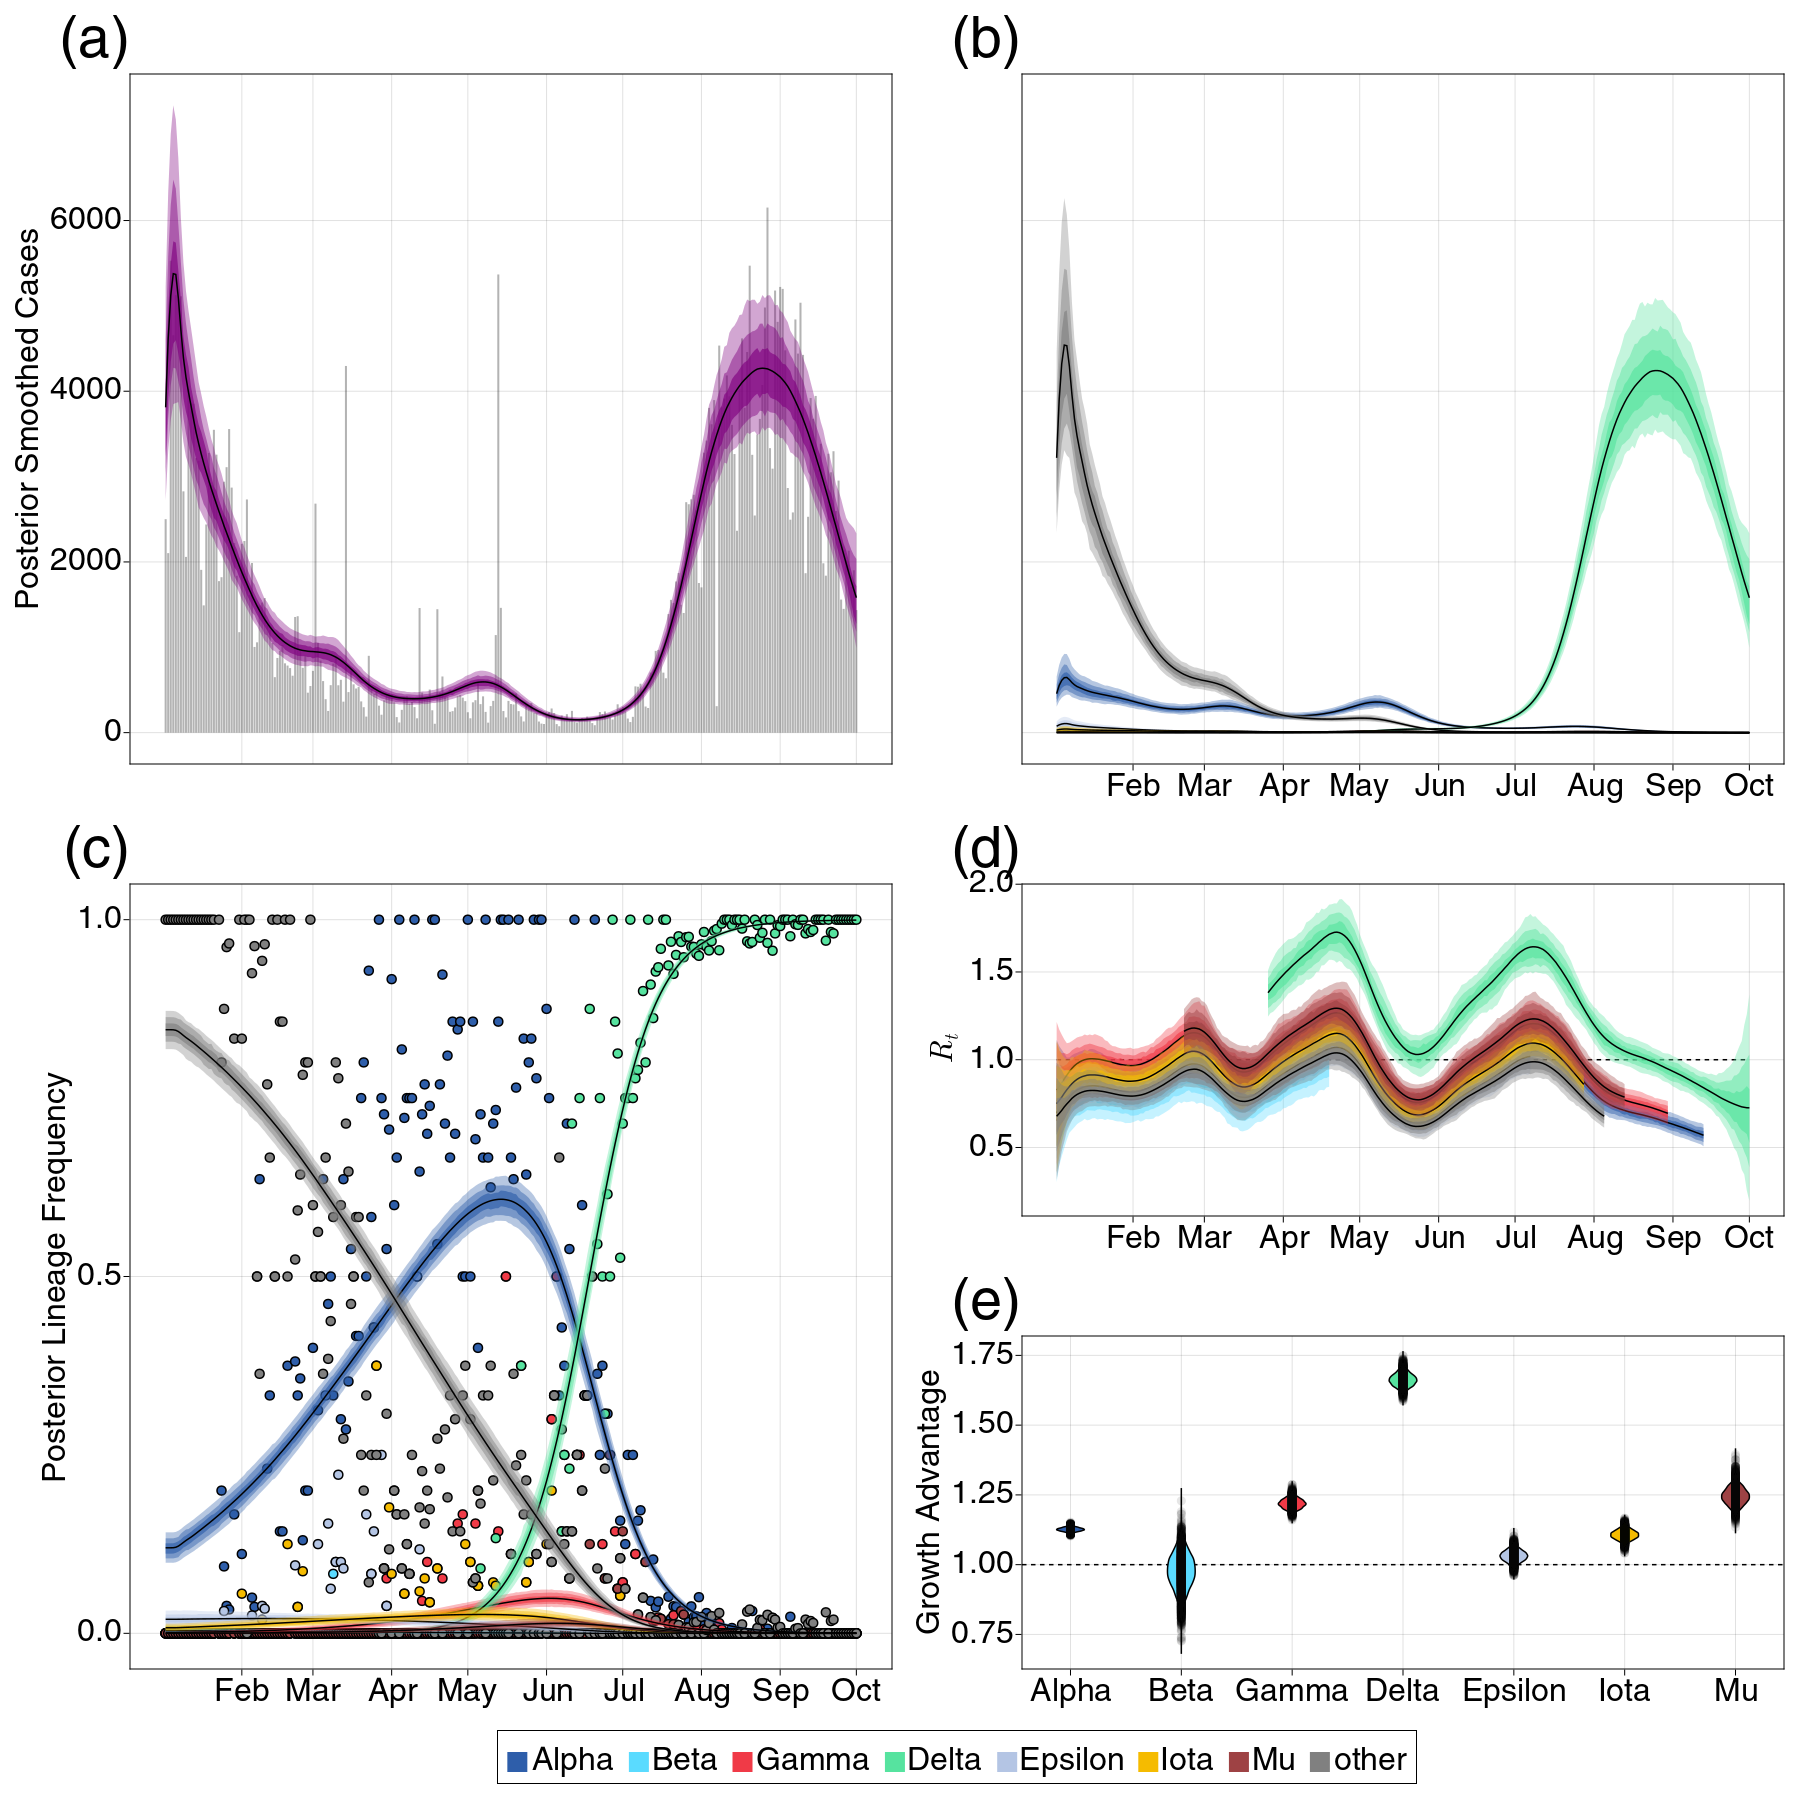

In [60]:
figure_2(MS, LD, colors)

In [64]:
function figure_1(MS, LD, colors; figsize=(3200, 2600), fontsize=32, font="Helvetica")
    dates_num, seed_L, forecast_L, N_lineage = unpack_data(MS)
    seq_labels = LD.seq_names
    dates = LD.dates 

    lineage_map = get_sequence_map(seq_labels)
    cases = MS.data["cases"]
    counts =  MS.data["num_sequenced"]
    plot_data = make_plot_dataframe(cases, counts, seq_labels)
    color_vec = [colors[i] for i in plot_data.lineage_num]
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (3200, 2600), fontsize = fontsize, font = font)
 
    g_cases_rt =  fig[1:3,1:2] = GridLayout()
    
    ##################### CASES AND AGGREGATE SMOOTH ###############
    ax_cases = Axis(g_cases_rt[1:2,1], ylabel = "Observed Cases")
    plot_cases!(ax_cases, MS)
    plot_smoothed_EC!(ax_cases, MS)
    add_monthly_dates!(ax_cases, LD.dates)
    hidexdecorations!(ax_cases, grid = false)
    
    ###################### AVERAGE RT ##############################
    ax_average_rt = Axis(g_cases_rt[3,1], ylabel = L"R_{t}")
    plot_average_R!(ax_average_rt, MS)
    add_monthly_dates!(ax_average_rt, LD.dates)
    linkxaxes!(ax_cases, ax_average_rt)

    g_variant = fig[1:3, 3:4] = GridLayout()
    
    ###################### Lineage Prevalence ######################
    ax_smooth_lin = Axis(g_variant[1:2,1:2])
    plot_lineage_prev!(ax_smooth_lin, MS, colors = colors)
    add_monthly_dates!(ax_smooth_lin, LD.dates)
    hidexdecorations!(ax_smooth_lin, grid = false)
    
    ###################### Lineage Effective Reproductive Number ###
    ax_Rt = Axis(g_variant[3,1:2])
    plot_lineage_R_censored!(ax_Rt, MS, colors = colors)
    add_monthly_dates!(ax_Rt, LD.dates)
    linkxaxes!(ax_smooth_lin, ax_Rt)

    ##################### PLOTTING ORIGINAL SAMPLES ################
    g_seq_count = fig[4:5,1:4] = GridLayout()
    
    ax_obs_cases = Axis(g_seq_count[1:2,2], ylabel = "Observed Cases")
    plot_cases!(ax_obs_cases, MS)
    add_monthly_dates!(ax_obs_cases, LD.dates, skip = 2)
    
    ax_seq_count = Axis(g_seq_count[1,1], ylabel = "Observed Counts")
    barplot!(ax_seq_count, plot_data.date, plot_data.counts, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    ##################### PLOTTING OBSERVED FREQ ################
    ax_seq_freq = Axis(g_seq_count[2,1], ylabel = "Sample Frequency")
    barplot!(ax_seq_freq, plot_data.date, plot_data.obs_freqs, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    linkxaxes!(ax_seq_count, ax_seq_freq)
    hidexdecorations!(ax_seq_count, grid = false)
    
    add_monthly_dates!(ax_seq_freq, LD.dates, skip=2)

    
    ##################### PLOTTING APPROX LINEAGE ################
    
    ax_true_cases = Axis(g_seq_count[1:2,3])
    
    sim_freq = get_posterior(MS, "sim_freq", true)
    med, lQ, uQ = get_quants(sim_freq, ps)
    
    plot_data.sim_freqs = reduce(vcat, [m for m in eachcol(med)])
    barplot!(ax_true_cases, plot_data.date, plot_data.cases .* plot_data.sim_freqs, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    add_monthly_dates!(ax_true_cases, LD.dates, skip=2)

    linkyaxes!(ax_obs_cases, ax_true_cases)
    hideydecorations!(ax_true_cases, grid = false)

    for (label, layout) in zip(["(a)", "(b)", "(c)"], [g_cases_rt, g_seq_count, g_variant])
    Label(layout[1, 1, TopLeft()], label,
        textsize = fontsize * 1.8,
        padding = (0, 5, 5, 0),
        font = font,
        halign = :right)
    end
    
    return fig
end

figure_1 (generic function with 1 method)

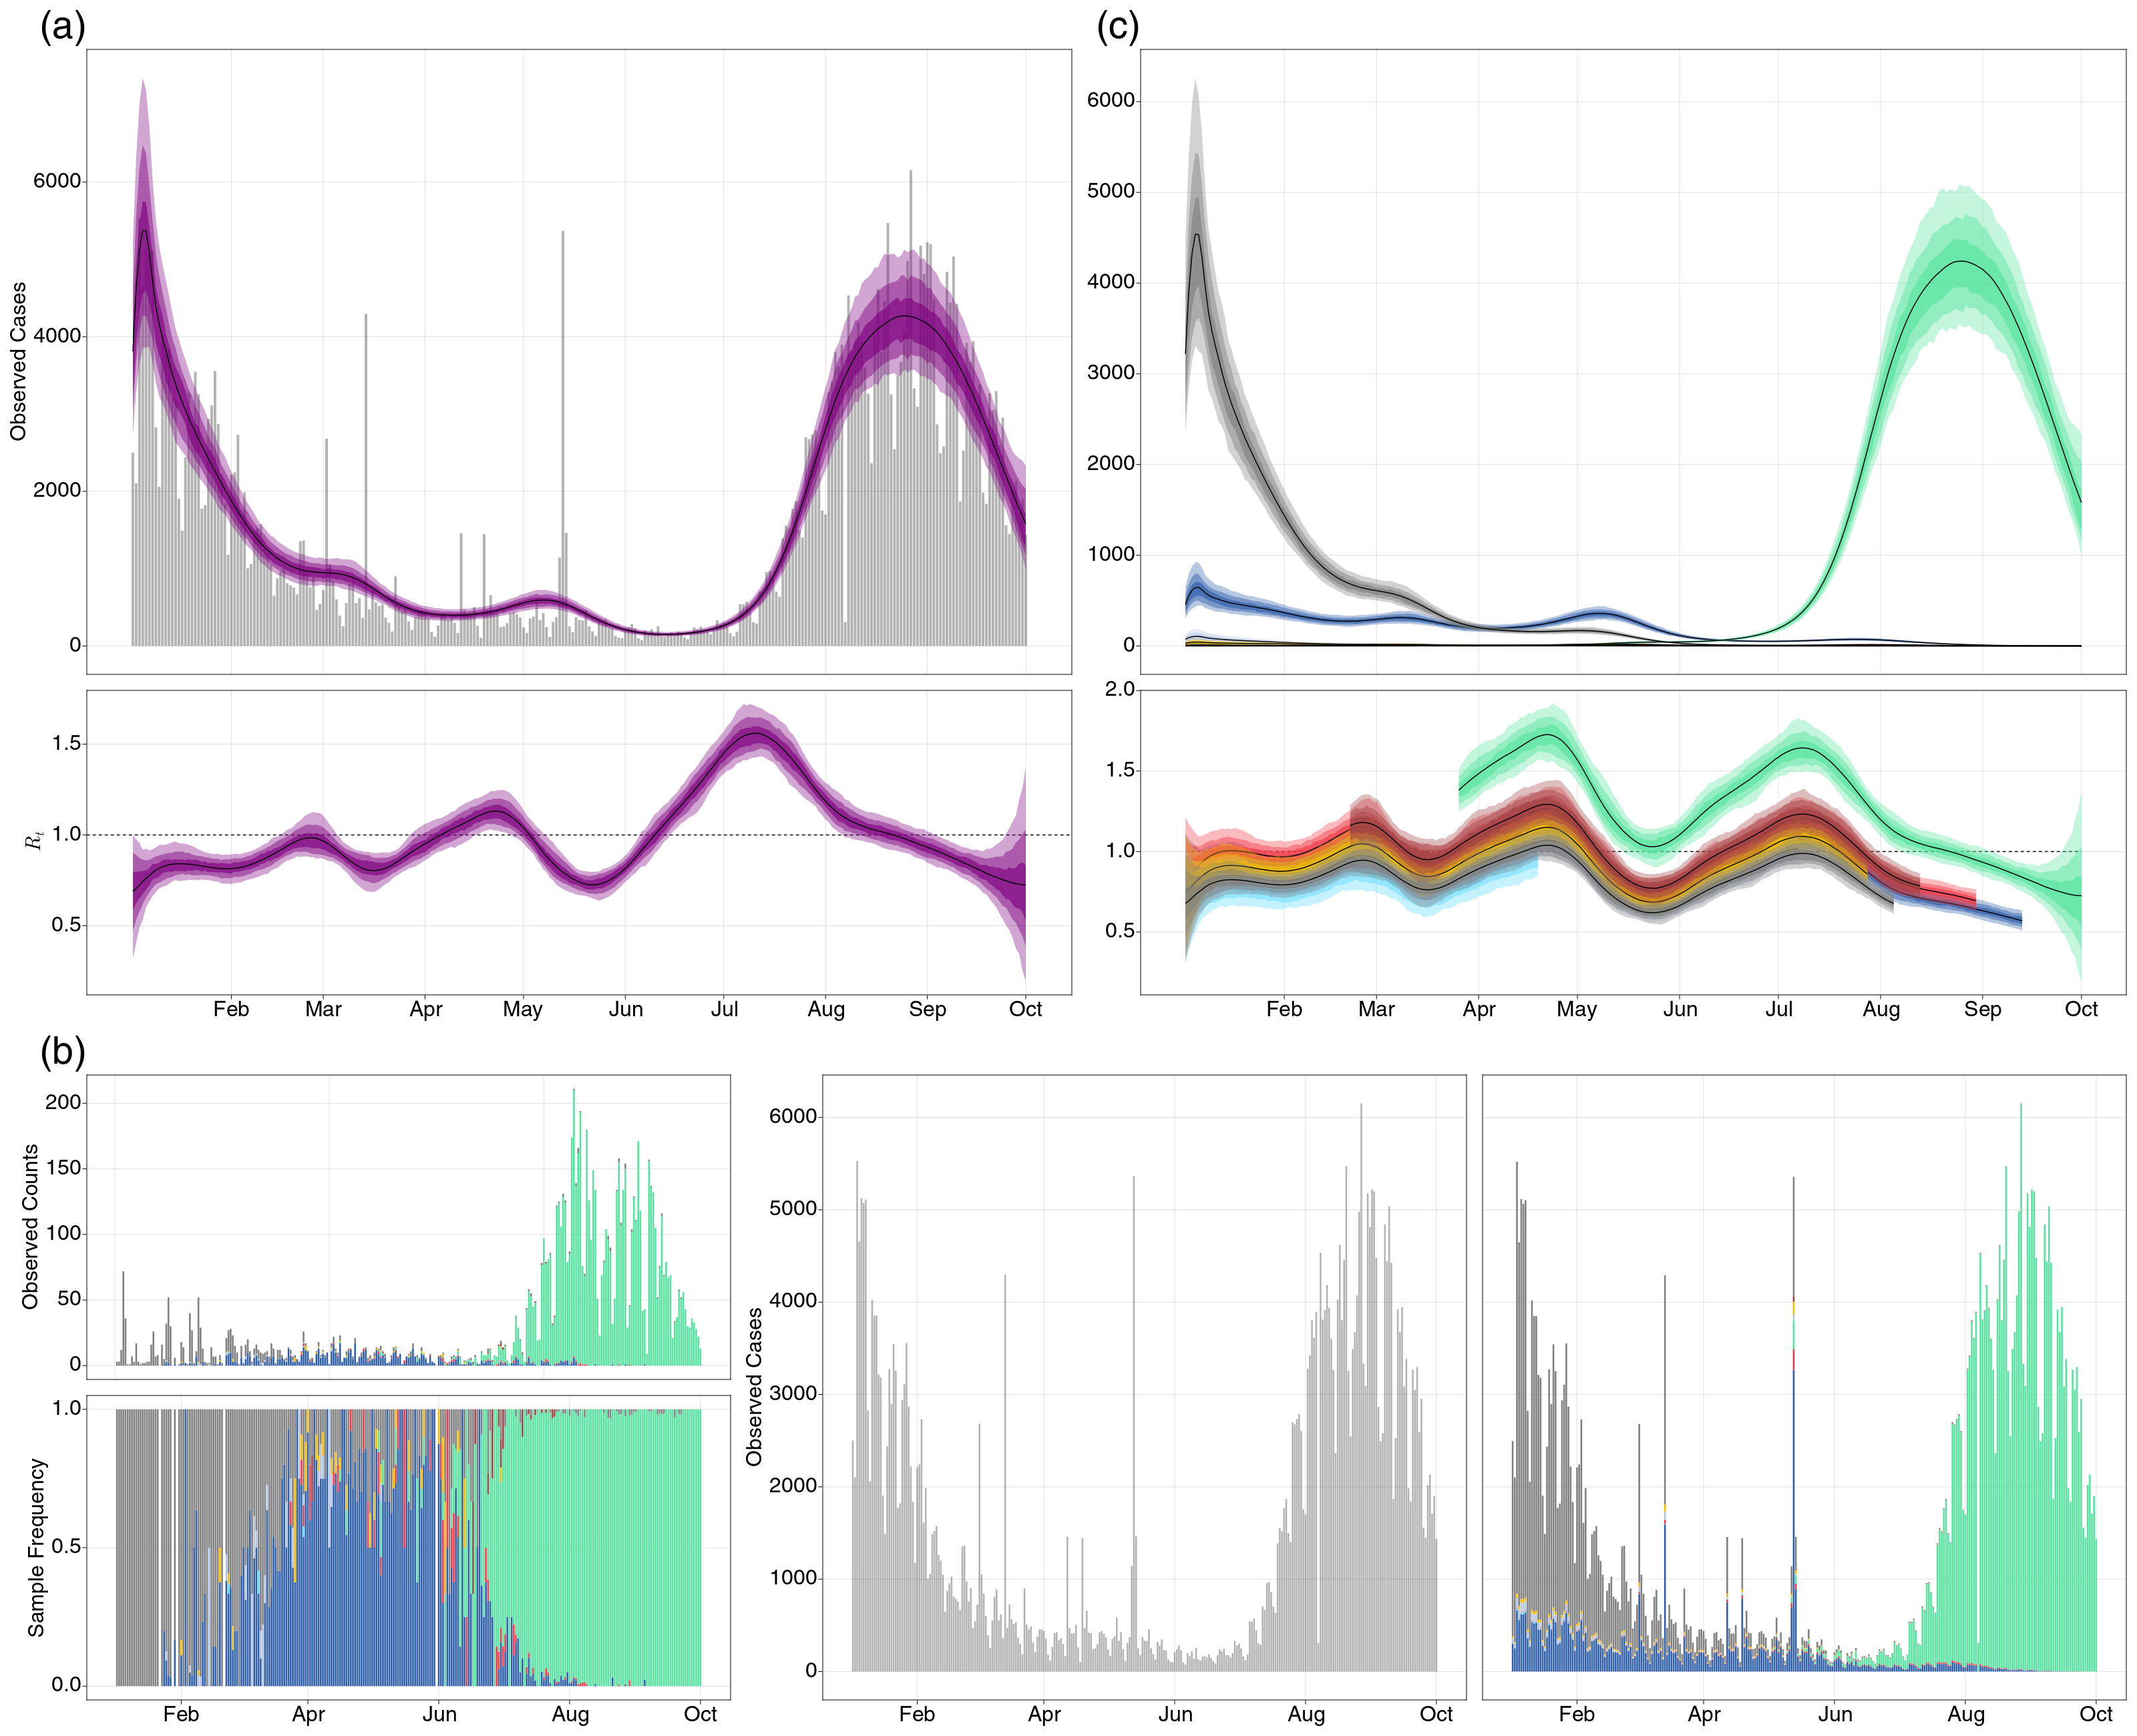

In [65]:
figure_1(MS, LD, colors)